In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import pickle

from aita_suite import *


In [2]:
CI02 = utils.load_data("data/for_learning_plus/CI02.npy")
CI04 = utils.load_data("data/for_learning_plus/CI04.npy")
CI06 = utils.load_data("data/for_learning_plus/CI06.npy")
CI09 = utils.load_data("data/for_learning_plus/CI09.npy")
CI21 = utils.load_data("data/for_learning_plus/CI21.npy")

In [3]:
file = open('data/craft/CI02.xr', 'rb')
ds_CI02 = pickle.load(file)
file.close()

maps = ds_CI02.aita.dist2eachTJ()
CI02['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()

file = open('data/craft/CI04.xr', 'rb')
ds_CI04 = pickle.load(file)
file.close()

maps = ds_CI04.aita.dist2eachTJ()
CI04['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()

file = open('data/craft/CI06.xr', 'rb')
ds_CI06 = pickle.load(file)
file.close()

maps = ds_CI06.aita.dist2eachTJ()
CI06['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()

file = open('data/craft/CI09.xr', 'rb')
ds_CI09 = pickle.load(file)
file.close()

maps = ds_CI09.aita.dist2eachTJ()
CI09['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()

file = open('data/craft/CI21.xr', 'rb')
ds_CI21 = pickle.load(file)
file.close()

maps = ds_CI21.aita.dist2eachTJ()
CI21['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()

In [4]:
TJ_CI02 = CI02.where(CI02.dist2TJ < 10)
TJ_CI04 = CI04.where(CI04.dist2TJ < 10)
TJ_CI06 = CI06.where(CI06.dist2TJ < 10)
TJ_CI09 = CI09.where(CI09.dist2TJ < 10)
TJ_CI21 = CI21.where(CI21.dist2TJ < 10)

l1 = [TJ_CI02,TJ_CI04,TJ_CI06,TJ_CI09,TJ_CI21]

In [5]:
TJL_CI02 = TJ_CI02.copy()
TJL_CI04 = TJ_CI04.copy()
TJL_CI06 = TJ_CI06.copy()
TJL_CI09 = TJ_CI09.copy()
TJL_CI21 = TJ_CI21.copy()

l2 = [TJL_CI02,TJL_CI04,TJL_CI06,TJL_CI09,TJL_CI21]

In [6]:
for k in range(len(l1)):
    for i in tqdm(l1[k].idTJ.unique()[1:]):
        n = len(l1[k][l1[k].idTJ==i].Y)
        if sum(l1[k][l1[k].idTJ==i].Y)>(n/10): # 10%
            l2[k].loc[(l2[k].idTJ == i),'Y'] = 1
        else:
            l2[k].loc[(l2[k].idTJ == i),'Y'] = 0

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

In [9]:
from sklearn import svm

In [10]:
X1 = TJL_CI02.iloc[:, 1:15]
X2 = TJL_CI04.iloc[:, 1:15]
X3 = TJL_CI06.iloc[:, 1:15]
X4 = TJL_CI09.iloc[:, 1:15]
X5 = TJL_CI21.iloc[:, 1:15]

y1 = TJL_CI02.iloc[:, 0]
y2 = TJL_CI04.iloc[:, 0]
y3 = TJL_CI06.iloc[:, 0]
y4 = TJL_CI09.iloc[:, 0]
y5 = TJL_CI21.iloc[:, 0]

y_patch1 = y1.copy()
y_patch2 = y2.copy()
y_patch3 = y3.copy()
y_patch4 = y4.copy()
y_patch5 = y5.copy()

In [11]:
X_train = pd.concat((X1,X3,X4,X5))
y_train = pd.concat((y1,y3,y4,y5))

X_train = X_train[~X_train.dist2TJ.isna()]
y_train = y_train[~y_train.isna()]

In [12]:
X_test = X2[~X2.dist2TJ.isna()]
y_test = y2[~y2.isna()]
y_patch = y_patch2

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
clf = svm.SVC(kernel="rbf")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [15]:
s = y_test[~y_test.isna()]
ind = 0
for i in s.index:
    y_patch[i] = y_pred[ind]
    ind += 1

In [25]:
y_patch_lab = pd.DataFrame((y_patch,CI04.idTJ)).T

In [26]:
for i in tqdm(y_patch_lab.idTJ.unique()):
    n = len(y_patch[(y_patch_lab.idTJ==i)&(~y_patch_lab.Y.isna())])
    if sum(y_patch[(y_patch_lab.idTJ==i)&(~y_patch_lab.Y.isna())])>(n/10):
        y_patch_lab.loc[(y_patch_lab.idTJ==i)&(~y_patch_lab.Y.isna()),'Y'] = 1
    else:
        y_patch_lab.loc[(y_patch_lab.idTJ==i)&(~y_patch_lab.Y.isna()),'Y'] = 0

  0%|          | 0/149 [00:00<?, ?it/s]

In [27]:
y_patch_lab.loc[(y_patch_lab.Y.isna()),'idTJ'] = np.nan

In [19]:
y_test_lab = TJL_CI04.loc[(~TJL_CI04.Y.isna()),['Y','idTJ']]
y_test_tj = y_test_lab.drop_duplicates()

In [28]:
y_pred_lab = pd.DataFrame((y_patch_lab[~y_patch_lab.Y.isna()].Y,y_test_lab['idTJ'])).T
y_pred_tj = y_pred_lab.drop_duplicates()

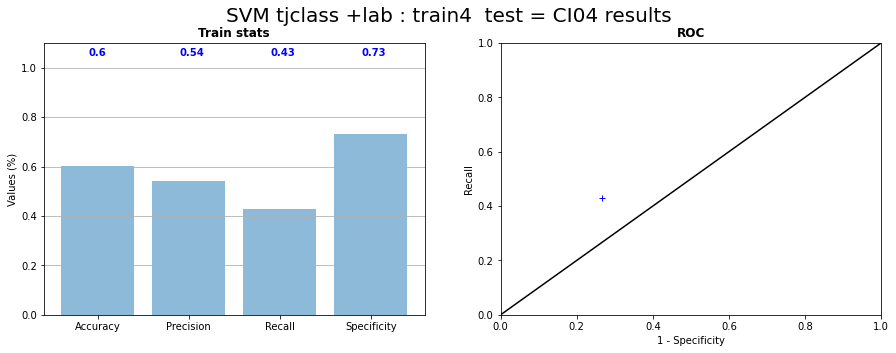

In [29]:
acc = metrics.accuracy_score(y_test_tj.Y, y_pred_tj.Y)
prec = metrics.precision_score(y_test_tj.Y, y_pred_tj.Y)
rec = metrics.recall_score(y_test_tj.Y, y_pred_tj.Y)
cm = metrics.confusion_matrix(y_test_tj.Y, y_pred_tj.Y)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="SVM tjclass +lab : train4  test = CI04")

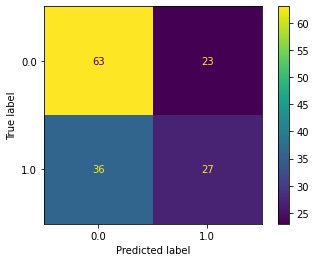

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test_tj.Y, y_pred_tj.Y)  
plt.show()

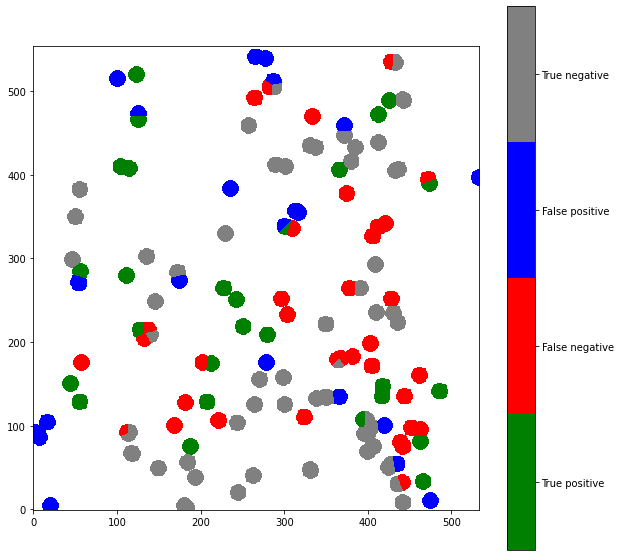

In [34]:
im_shape = np.shape(np.load("data/for_learning/CI04.npy"))
plt.figure(figsize=(10,10))
utils.plot_pred_proj(y_patch_lab.Y,y2,im_shape)

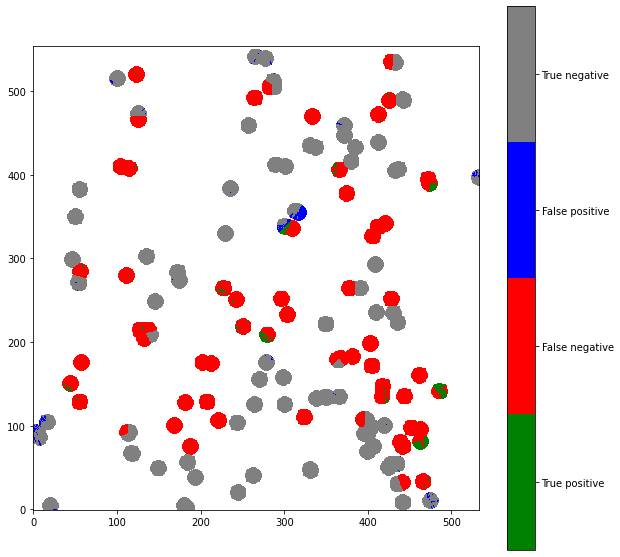

In [33]:
im_shape = np.shape(np.load("data/for_learning/CI04.npy"))
plt.figure(figsize=(10,10))
utils.plot_pred_proj(y_patch,y2,im_shape)